In [1]:
import numpy as np
# Set numpy to print only 2 decimal digits for neatness
np.set_printoptions(precision=2, suppress=True)

In [2]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dltk.io import preprocessing
from skimage import filters

import os
import gzip
import tarfile


In [3]:
import shutil
import tensorflow as tf

from nipype.interfaces import fsl
from nipype.interfaces.fsl import BET
from nipype.testing import example_data

2022-11-25 07:47:51.562767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/fsl/5.0
2022-11-25 07:47:51.562826: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
IMG_SHAPE = (78, 110, 86)
IMG_2D_SHAPE = (IMG_SHAPE[1] * 4, IMG_SHAPE[2] * 4)
#SHUFFLE_BUFFER = 5 #Subject to change
N_CLASSES = 3

In [5]:
def resample_img(itk_image, out_spacing=[2.0, 2.0, 2.0]):
    ''' This function resamples images to 2-mm isotropic voxels.
      
        Parameters:
            itk_image -- Image in simpleitk format, not a numpy array
            out_spacing -- Space representation of each voxel
            
        Returns: 
            Resulting image in simpleitk format, not a numpy array
    '''
    
    # Resample images to 2mm spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In [6]:
def registrate(sitk_fixed, sitk_moving, bspline=False):
    ''' Perform image registration using SimpleElastix.
        By default, uses affine transformation.
        
        Parameters:
            sitk_fixed -- Reference atlas (sitk .nii)
            sitk_moving -- Image to be registrated
                           (sitk .nii)
            bspline -- Whether or not to perform non-rigid
                       registration. Note: it usually deforms
                       the images and increases execution times
    '''
    
    elastixImageFilter = sitk.ElastixImageFilter()#sitk.ElastixImageFilter()   SimpleElastix()
    elastixImageFilter.SetFixedImage(sitk_fixed)
    elastixImageFilter.SetMovingImage(sitk_moving)

    parameterMapVector = sitk.VectorOfParameterMap()
    parameterMapVector.append(sitk.GetDefaultParameterMap("affine"))
    if bspline:
        parameterMapVector.append(sitk.GetDefaultParameterMap("bspline"))
    elastixImageFilter.SetParameterMap(parameterMapVector)

    elastixImageFilter.Execute()
    return elastixImageFilter.GetResultImage()

In [7]:
def skull_strip_nii(original_img, destination_img, frac=0.2): #
    ''' Practice skull stripping on the given image, and save
        the result to a new .nii image.
        Uses FSL-BET 
        (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide#Main_bet2_options:)
        
        Parameters:
            original_img -- Original nii image
            destination_img -- The new skull-stripped image
            frac -- Fractional intensity threshold for BET
    '''
    
    btr = fsl.BET()
    btr.inputs.in_file = original_img
    btr.inputs.frac = frac
    btr.inputs.out_file = destination_img
    btr.cmdline
    res = btr.run()
    return res

In [8]:
def slices_matrix_2D(img):
  ''' Transform a 3D MRI image into a 2D image, by obtaining 9 slices 
      and placing them in a 4x4 two-dimensional grid.
      
      All 16 cuts are from a horizontal/axial view. They are selected
      from the 30th to the 60th level of the original 3D image.
      
      Parameters:
        img -- np.ndarray with the 3D image
        
      Returns:
        np.ndarray -- The resulting 2D image
  '''
  
  # create the final 2D image 
  image_2D = np.empty(IMG_2D_SHAPE)
  
  # set the limits and the step
  TOP = 60
  BOTTOM = 30
  STEP = 2
  N_CUTS = 16
  
  # iterator for the cuts
  cut_it = TOP
  # iterator for the rows of the 2D final image
  row_it = 0
  # iterator for the columns of the 2D final image
  col_it = 0
  
  for cutting_time in range(N_CUTS):
    
    # cut
    cut = img[cut_it, :, :]
    cut_it -= STEP
    
    # reset the row iterator and move the
    # col iterator when needed
    if cutting_time in [4, 8, 12]:
      row_it = 0
      col_it += cut.shape[1]
    
    # copy the cut to the 2D image
    for i in range(cut.shape[0]):
      for j in range(cut.shape[1]):
        image_2D[i + row_it, j + col_it] = cut[i, j]
    row_it += cut.shape[0]
  
  # return the final 2D image, with 3 channels
  # this is necessary for working with most pre-trained nets
  return np.repeat(image_2D[None, ...], 3, axis=0).T

In [9]:
def load_image_2D(abs_path): #, labels
  ''' Load an image (.nii) and its label, from its absolute path.
      Transform it into a 2D image, by obtaining 16 slices and placing them
      in a 4x4 two-dimensional grid.
      
      Parameters:
        abs_path -- Absolute path, filename included
        labels -- Label mapper
        
      Returns:
        img -- The .nii image, converted into a numpy array
        label -- The label of the image (from argument 'labels')
        
  '''
  
  # obtain the label from the path (it is the last directory name)
  #label = labels[abs_path.split('/')[-2]]
  
  # load the image with SimpleITK
  sitk_image = sitk.ReadImage(abs_path)
  
  # transform into a numpy array
  img = sitk.GetArrayFromImage(sitk_image)
  
  # apply whitening
  img = preprocessing.whitening(img)
  
  # make the 2D image
  img = slices_matrix_2D(img)
  
  return img#, label

In [10]:
def gz_extract(zipfile):
    file_name = (os.path.basename(zipfile)).rsplit('.',1)[0] #get file name for file within
    with gzip.open(zipfile,"rb") as f_in, open(f"{zipfile.split('/')[0]}/{file_name}","wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
    os.remove(zipfile) # delete zipped file
    # return f"{zipfile.split('/')[0]}/{file_name}"

In [11]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy() # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a floast_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
  array = tf.io.serialize_tensor(array)
  return array

In [12]:
def write_tfrecords(x, y, filename):
    writer = tf.io.TFRecordWriter(filename)

    for image, label in zip(x, y):
        example = tf.train.Example(features=tf.train.Features(
            feature={
                'image': _bytes_feature(serialize_array(image)), #tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.tobytes()])),
                'label': _int64_feature(label) #tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            }))
        writer.write(example.SerializeToString())


In [13]:
def _parse_image_function(example_proto):
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    features = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.io.parse_tensor(features['image'], out_type=tf.double) #tf.io.decode_raw(features['image'], tf.float32) 
   # image.set_shape([3 * 344 * 440])
    image = tf.reshape(image, [344, 440, 3])

    label = tf.cast(features['label'], tf.int32)
    label = tf.one_hot(features['label'], 3)

    return image, label

In [14]:
def read_dataset(epochs, batch_size, filename):

    # filenames = [os.path.join(channel, channel_name + '.tfrecords')]
    dataset = tf.data.TFRecordDataset(filename)

    dataset = dataset.map(_parse_image_function, num_parallel_calls=10)
    dataset = dataset.shuffle(buffer_size=10 * batch_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(batch_size)#(10)

    return dataset

In [15]:
categories = ['CN', 'MCI', 'AD']
category_dict = {'CN':0, 'MCI':1, 'AD':2}
nifti_files = []
labels = []

newpath = f"./Nifti_files/"
for category in categories:
    path = f"./{category}/"   
# r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if '.nii' in file:
                nifti_files.append(os.path.join(r, file))
                label = category_dict[category]#0 if category=='CN' else 1 if category=='MCI' else 2
                labels.append(label)
                
print(nifti_files[0:5])
print(labels[0:5])

['./CN/114_S_0416/MPR__GradWarp__B1_Correction__N3__Scaled/2009-07-29_17_15_32.0/S71817/ADNI_114_S_0416_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20100429101118348_S71817_I172320.nii', './CN/029_S_0843/MPR__GradWarp__B1_Correction__N3__Scaled/2006-09-13_12_19_12.0/S18909/ADNI_029_S_0843_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070810175504250_S18909_I66997.nii', './CN/073_S_0089/MPR-R__GradWarp__B1_Correction__N3__Scaled/2008-02-14_15_53_44.0/S45723/ADNI_073_S_0089_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20080229181343391_S45723_I94601.nii', './CN/073_S_0089/MPR-R__GradWarp__B1_Correction__N3__Scaled/2009-02-02_15_17_58.0/S62604/ADNI_073_S_0089_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20090212095017669_S62604_I135801.nii', './CN/073_S_0089/MPR__GradWarp__B1_Correction__N3__Scaled_2/2006-08-31_16_34_37.0/S18499/ADNI_073_S_0089_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081006105144032_S18499_I119228.nii']
[0, 0, 0, 0, 0]


In [16]:
atlas = sitk.ReadImage('average305_t1_tal_lin_mask.nii')
atlas = resample_img(atlas)

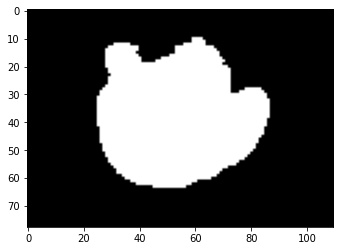

In [17]:
atlas_array = sitk.GetArrayFromImage(atlas)
plt.imshow(atlas_array[:, :, 70], cmap='gray')
plt.show()

In [18]:
#res = resample_img(nifti_files[0], out_spacing=[2.0, 2.0, 2.0])

for image in nifti_files:
    sitk_image = sitk.ReadImage(image)
# transform into a numpy array
    sitk_array = sitk.GetArrayFromImage(sitk_image)
    
    res_image = resample_img(sitk_image)
    res_array = sitk.GetArrayFromImage(res_image)
    res_array = preprocessing.resize_image_with_crop_or_pad(res_array, img_size=(128, 192, 192), mode='symmetric')
    res_array = preprocessing.whitening(res_array)
    
    registrated_image = registrate(atlas, res_image, bspline=False)
    sitk.WriteImage(registrated_image, f"Registrated/{image.split('/')[-1]}_registrated.nii")
    
    registrated_image = sitk.ReadImage(f"Registrated/{image.split('/')[-1]}_registrated.nii")
    registrated_array = sitk.GetArrayFromImage(registrated_image)
    
    skull_strip_nii(f"Registrated/{image.split('/')[-1]}_registrated.nii", f"Skull_Stripped/{image.split('/')[-1]}_stripped.nii", frac=0.2)
    gz_extract(f"Skull_Stripped/{image.split('/')[-1]}_stripped.nii.gz")



/home/atulya/.pyenv/versions/lewagon/lib/python3.8/site-packages/dltk/io/preprocessing.py:87: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad(image[slicer], to_padding, **kwargs)


Installing all components.
InstallingComponents was successful.

ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images...
Reading images took 0 ms.

  A default pyramid schedule is used.
  A default pyramid schedule is used.
  The default value "false" is used instead.
  The default value "GeometricalCenter" is used instead.
Transform parameters are initialized as: [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
InitializeTransform took 0.00s
Scales are estimated automatically.
Scales for transform parameters are: [2577, 4177, 2129, 2577, 4177, 2129, 2577, 4177, 2129, 1, 1, 1

In [ ]:
ss_images = os.listdir('Skull_Stripped')

for image in ss_images:
    image_2d = load_image_2D(f"Skull_Stripped/{image}")
 #   print(image_2d.shape)
    np.save(f"Image_2d/{image.split('/')[-1]}_2d", image_2d)

In [ ]:
list_arrays = []
for filename in os.listdir("Image_2d"):
    if filename.endswith('.npy'):
        list_arrays.append(np.load(f"Image_2d/{filename}")) 
        
list_arrays = np.array(list_arrays)
list_arrays.shape

In [ ]:
write_tfrecords(list_arrays, labels, "./subset.tfrecords")

In [ ]:
Train = read_dataset(10, 10, './subset.tfrecords')

In [ ]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    input_shape=(344, 440, 3), 
    weights='imagenet', 
    include_top=False,
    pooling='max'
)

base_output = base_model.output
hidden_layer = tf.keras.layers.Dense(512, activation='relu')(base_output)
hl_reg = tf.keras.layers.Dropout(0.8)(hidden_layer)
output_layer = tf.keras.layers.Dense(3, activation='softmax')(hl_reg)
inception_model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

for layer in base_model.layers:
    layer.trainable = False

# compile the model 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-3)
inception_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
inception_model.fit(Train,epochs=1)

In [1]:
print(len(os.listdir('./AD')))
print(len(os.listdir('./CN')))
print(len(os.listdir('./MCI')))

38
55
80


In [2]:
print(len(os.listdir('./Skull_Stripped')))

47
